# Add flow

    syn to see what timing is --> CLOCK PERIOD
    power-rtl to generate checkpoint

    generate testbench (vectors, clock period)
    sim-rtl
    redo-power-rtl (load checkpoint)


In [1]:
import yaml
import os
import matplotlib.pyplot as plt
import numpy as np


design='sramtest'
pdk='sky130'
# pdk='intech22'
tools='cm'

dut_instance='sramtest_dut'

root_dir=os.path.abspath(f"{os.getcwd()}/../")
src_dir=f"{root_dir}/src"
build_dir=f"{root_dir}/build-{pdk}-{tools}/{design}"
out_dir=os.path.abspath(f"{os.getcwd()}/../../out")
jpower_reports_dir = f"{out_dir}/jpower-reports/{design}-{pdk}"
generated_src_dir = f"{root_dir}/generated-src"
generated_configs_dir = f"{root_dir}/generated-configs"
bsub="bsub -q normal"
overwrite=True

os.makedirs(generated_src_dir, exist_ok=True)
os.makedirs(generated_configs_dir, exist_ok=True)


## Useful Functions

In [2]:
def decode_sram(sram_name):
    args = [int(i) for i in sram_name.replace('sram22_',  '').replace('x', ' ').replace('w', ' ').replace('m', ' ').split()]
    addr_width = int(np.log2(args[0]))
    data_width = args[1]
    mux = args[2]
    wmask_width = int(data_width / args[3])
    size = int(args[0]*data_width/8)
    return (addr_width, data_width, mux, wmask_width, size)

def get_srams():
    srams = ["sram22_64x4m4w2", "sram22_64x32m4w8", "sram22_256x32m4w8", "sram22_512x32m4w8", "sram22_1024x32m8w8", "sram22_2048x32m8w8", "sram22_4096x32m8w8"]
    return srams 

def binarySize(tb_name):
    return tb_name.split('-')[-1]


def generate_sram(sram_name):
    addr_width, data_width, mux, wmask_width, size = decode_sram(sram_name)
    module = "sramtest_" + f"{int(np.exp2(addr_width))}x{data_width}_{size}B"
    verilog=f"""\
    module {module} (
        clock,we,wmask,addr,din,dout
    );

    parameter DATA_WIDTH = {data_width};
    parameter ADDR_WIDTH = {addr_width} ;
    parameter WMASK_WIDTH = {wmask_width} ;
    parameter RAM_DEPTH = 1 << ADDR_WIDTH;

    input  clock; // clock
    input  we; // write enable
    input [WMASK_WIDTH-1:0] wmask; // write mask
    input [ADDR_WIDTH-1:0]  addr; // address
    input [DATA_WIDTH-1:0]  din; // data in
    output [DATA_WIDTH-1:0] dout; // data out

    // need these internal registers for sramtest module to synthesize properly
    reg  we_reg; // write enable
    reg [WMASK_WIDTH-1:0] wmask_reg; // write mask
    reg [ADDR_WIDTH-1:0]  addr_reg; // address
    reg [DATA_WIDTH-1:0]  din_reg; // data in
    
    always@(posedge clock) begin
        we_reg <= we;
        wmask_reg <= wmask;
        addr_reg <= addr;
        din_reg <= din;
    end

    {sram_name} mem0 (
    .clk(clock),.we(we_reg),.wmask(wmask_reg),
    .addr(addr_reg),.din(din_reg),.dout(dout)
    );

    endmodule
    """

    with open(f"{src_dir}/{module}.v",'w') as f:
        f.write(verilog)
    return module

def generate_verilog(sram_name,CLOCK_PERIOD=1):
    addr_width, data_width, mux, wmask_width, size = decode_sram(sram_name)
    module = "sramtest_" + f"{int(np.exp2(addr_width))}x{data_width}_{size}B"
    tb_name= "sramtest-" + f"{int(np.exp2(addr_width))}x{data_width}-{size}B"
    verilog=f"""\
    `timescale 1ns/10ps
    
    module sramtest_tb;

        parameter DATA_WIDTH = {data_width} ;
        parameter ADDR_WIDTH = {addr_width} ;
        parameter WMASK_WIDTH = {wmask_width} ;
        parameter RAM_DEPTH = 1 << ADDR_WIDTH;

        reg clk = 0;
        always #({CLOCK_PERIOD}/2.0) clk = ~clk;

        reg  we; // write enable
        reg [WMASK_WIDTH-1:0] wmask; // write mask
        reg [ADDR_WIDTH-1:0]  addr; // address
        reg [DATA_WIDTH-1:0]  din; // data in
        wire [DATA_WIDTH-1:0] dout; // data out

        {module} sramtest_dut (
            .clock(clk),.we(we),.wmask(wmask),
            .addr(addr),.din(din),.dout(dout)
        );
    """
    verilog += """\
        initial begin
            // reset - SRAM behavioral verilog resets all values to 0
            din = {DATA_WIDTH{1'b1}}; wmask = {WMASK_WIDTH{1'b1}}; addr = {ADDR_WIDTH{'b0}}; we = 0'b0;
            // load vals
            @(negedge clk);
            // enable SRAM write
            we = 1'b1;
            @(posedge clk); // we --> we_reg in sramtest
            @(negedge clk);
            $fsdbDumpfile("output.fsdb"); $fsdbDumpvars("+all"); $fsdbDumpon;
            // perform SRAM write
            @(posedge clk);
            // stop dumping
            @(negedge clk);
            $display("Wrote %d to address %d",din,addr);
            $fsdbDumpoff;
            // sanity check: re-read same value
            we = 1'b0; // enable SRAM read
            @(posedge clk); // we --> we_reg in sramtest
            @(posedge clk); // perform SRAM read
            @(negedge clk); // read out data
            $display("Read %d from address %d",dout,addr);
            // $fsdbDumpoff;
            $finish;
        end

    endmodule
    """
    with open(f"{generated_src_dir}/{tb_name}.v",'w') as f:
        f.write(verilog)
    return tb_name



def generate_config(tb_name, module):
    cfg = {
        'vlsi.core.power_tool': "hammer.power.joules",

        'power.inputs':
        {
            'level': 'rtl',
            'input_files': [f"src/{module}.v"],
            'top_module': f"{module}",
            'tb_name': "sramtest_tb",
            'tb_dut': "sramtest_dut",
            'waveforms': [],
            # 'waveforms': ["build-intech22-cm/add8/sim-rtl-rundir/output.fsdb"],
            'report_configs':[
                {
                # 'waveform_path': f"{build_dir}/sim-rtl-rundir/{tb_name}.fsdb",
                'waveform_path': f"{root_dir}/build-{pdk}-{tools}/{tb_name}/sim-rtl-rundir/output.fsdb",
                # 'interval_size': '0.5ns',
                'toggle_signal': 'clock',
                'num_toggles': 1,
                'report_name': tb_name,
                'output_formats': ['plot_profile', 'report']
                }
            ]
        },
        'power.inputs.power_spec': "auto",
        # sim clock has to match synthesized clock period
        'sim.inputs':
        {
            'input_files': [f'src/{module}.v', f'{generated_src_dir}/{tb_name}.v'],
            'defines': ["CLOCK_PERIOD=10"],
            'defines_meta': 'append',
            'options': ['-timescale=1ns/10ps'],
            'options_meta': 'append'
        },
        'synthesis.inputs': 
        {
            'top_module': f"{module}",
            'input_files': [f"src/{module}.v"]
        },
        'vlsi.inputs.clocks': [
            {'name': "clock", 'period': "10ns", 'uncertainty': "10ps"}
        ]
    }
    with open(f"{generated_configs_dir}/{tb_name}.yml",'w') as f:
        yaml.dump(cfg,f,sort_keys=False)


In [3]:
# one-time design setup
print(f"""
make syn design={design} pdk={pdk} -B
make power-rtl design={design} pdk={pdk} -B
""")


make syn design=sramtest pdk=sky130 -B
make power-rtl design=sramtest pdk=sky130 -B



In [4]:
srams = get_srams()
tests = []

for sram in srams:

    module = generate_sram(sram)
    tb_name=generate_verilog(sram) 
    # print(f"""
    # make syn design={module} pdk={pdk} -B
    # make power-rtl design={module} pdk={pdk} -B""")
    generate_config(tb_name, module)
    cmd = ""
    fsdb_path = f"{root_dir}/build-{pdk}-{tools}/{tb_name}/sim-rtl-rundir/{tb_name}.fsdb"
    if overwrite or not os.path.exists(fsdb_path):
        cmd += f"""make syn design=sramtest pdk={pdk} POWER_CONF={generated_configs_dir}/{tb_name}.yml OBJ_DIR=build-{pdk}-{tools}/{tb_name}"""
    rpt_path = f"{build_dir}/power-rtl-rundir/reports/{tb_name}.power.rpt"
    if overwrite or not os.path.exists(rpt_path):
        if len(cmd) > 0: cmd += " && "
        cmd += f"""make power-rtl design=sramtest pdk={pdk} POWER_CONF={generated_configs_dir}/{tb_name}.yml OBJ_DIR=build-{pdk}-{tools}/{tb_name}"""
    if len(cmd) > 0:
        # print(f"{bsub} '{cmd}'")
        print(cmd)
    tests.append(tb_name)


make syn design=sramtest pdk=sky130 POWER_CONF=/bwrcq/scratch/vinaya/energy-char/generated-configs/sramtest-64x4-32B.yml OBJ_DIR=build-sky130-cm/sramtest-64x4-32B && make power-rtl design=sramtest pdk=sky130 POWER_CONF=/bwrcq/scratch/vinaya/energy-char/generated-configs/sramtest-64x4-32B.yml OBJ_DIR=build-sky130-cm/sramtest-64x4-32B
make syn design=sramtest pdk=sky130 POWER_CONF=/bwrcq/scratch/vinaya/energy-char/generated-configs/sramtest-64x32-256B.yml OBJ_DIR=build-sky130-cm/sramtest-64x32-256B && make power-rtl design=sramtest pdk=sky130 POWER_CONF=/bwrcq/scratch/vinaya/energy-char/generated-configs/sramtest-64x32-256B.yml OBJ_DIR=build-sky130-cm/sramtest-64x32-256B
make syn design=sramtest pdk=sky130 POWER_CONF=/bwrcq/scratch/vinaya/energy-char/generated-configs/sramtest-256x32-1024B.yml OBJ_DIR=build-sky130-cm/sramtest-256x32-1024B && make power-rtl design=sramtest pdk=sky130 POWER_CONF=/bwrcq/scratch/vinaya/energy-char/generated-configs/sramtest-256x32-1024B.yml OBJ_DIR=build-sky

## Displaying results

In [35]:
tests_dict = {t: {} for t in tests}

In [36]:
### gather power and area data for each clock period
for tb_name in tests_dict:
    power_rpt_fpath = f"{root_dir}/build-{pdk}-{tools}/{tb_name}/power-rtl-rundir/reports/{tb_name}.hier.power.rpt"
    area_rpt_fpath  = f"{root_dir}/build-{pdk}-{tools}/{tb_name}/syn-rundir/reports/final_area.rpt"
    if not os.path.exists(power_rpt_fpath):
        print(power_rpt_fpath)
        continue
    if not os.path.exists(area_rpt_fpath):
        print(area_rpt_fpath)
        continue
    with open(power_rpt_fpath,'r') as f:
        for line in f.readlines():
            if line.strip().endswith(f"/{tb_name.replace('-', '_')}") and len(line.split())==8:
                words = line.split()
                tests_dict[tb_name]['leakage_power'] = float(words[2])
                tests_dict[tb_name]['internal_power'] = float(words[3])
                tests_dict[tb_name]['switching_power'] = float(words[4])
                tests_dict[tb_name]['total_power'] = float(words[5])
    with open(area_rpt_fpath,'r') as f:
        for line in f.readlines():
            if line.strip().startswith(tb_name.replace('-', '_')) and len(line.split())==5:
                words = line.split()
                tests_dict[tb_name]['cell_count'] = int(words[1])
                tests_dict[tb_name]['area'] = float(words[-1])

#leakage_power, internal_power, switching_power, total_power, cell_area, Cell_count

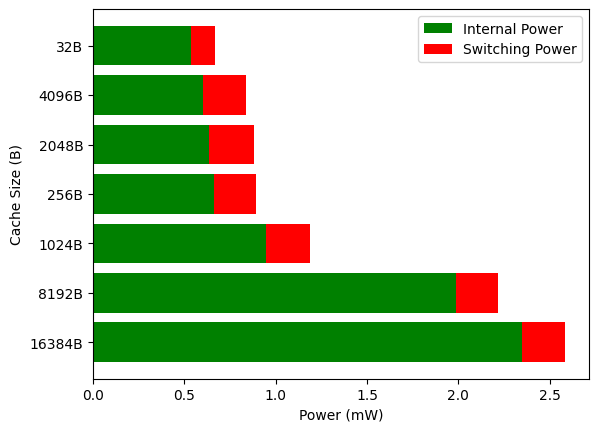

In [38]:
tests_sorted = [t for _,t in sorted([(tests_dict[t]['total_power'],t) for t in tests_dict if 'total_power' in tests_dict[t]])]
power_sorted = [tests_dict[t]['total_power'] for t in tests_sorted]
switching = [tests_dict[t]['switching_power'] for t in tests_sorted]
internal = [tests_dict[t]['internal_power'] for t in tests_sorted]
size = list(map(lambda x: int((binarySize(x)).replace('B', '')), tests_sorted))
names = list(map(binarySize, tests_sorted))

fig, ax = plt.subplots()

y_pos = np.arange(len(names))

# ax.barh(y_pos, power_sorted, align='center')
ax.barh(y_pos, internal, align='center', color='g', label='Internal Power')
ax.barh(y_pos, switching, left=internal, align='center', color='r', label='Switching Power')
ax.set_yticks(y_pos, labels=names)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Power (mW)')
ax.set_ylabel('Cache Size (B)')
plt.legend()
# plt.show()

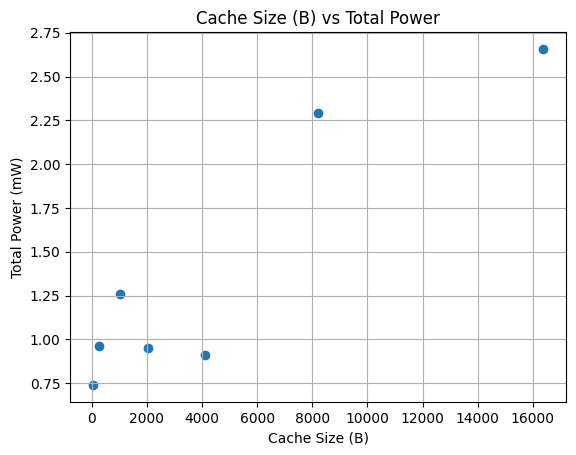

In [39]:
fig, ax = plt.subplots()
ax.scatter(size, power_sorted)

ax.set(xlabel='Cache Size (B)', ylabel='Total Power (mW)',
       title='Cache Size (B) vs Total Power (mW)')
ax.grid()

plt.show()